In [1]:
from tvb.simulator.lab import *
import numpy as np
import pylab as plt
from func_TVB import *
from func_FR import *

We load the two connectomes used for the simulations.

In [2]:
path_base = os.getcwd()

path_Dconn = os.path.join(path_base, 'data', 'connectivity', 'Dconn.zip' )
Dconn = connectivity.Connectivity.from_file(path_Dconn)
Dconn.configure()
W_Dconn=np.copy(Dconn.weights)

path_Hconn = os.path.join(path_base, 'data', 'connectivity', 'Hconn.zip' )
Hconn = connectivity.Connectivity.from_file(path_Hconn)
Hconn.configure()
W_Hconn=np.copy(Hconn.weights)

WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.


In [3]:
# set the optimal global coupling for the two connectomes.
G_Dconn=4.
Dconn.weights=W_Dconn*G_Dconn

G_Hconn=3.
Hconn.weights=W_Hconn*G_Hconn

# Spontaneous activity

## Dconn

In [36]:
# run the simulation
t_start = 1000
t_end = 4000 + t_start

_, _, data_V, _, _ = run_sim(params=LB_DconnParams(), conn=Dconn, 
                            stim_amp = 0, # spontaneous activity
                            sim_length=t_end)
data_V = data_V[t_start:]

Text(0, 0.5, 'V')

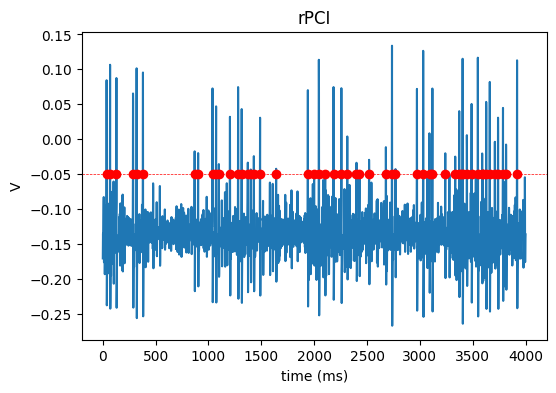

In [5]:
# spike detection
node = 13
ht = -0.05
t = np.arange(len(data_V))

tk = spike_detect(t, data_V[:,node], HardThreshold=ht)

plt.figure(figsize=(6,4))

plt.plot(t, data_V[:,node])
plt.plot(tk,np.repeat(ht,len(tk)),'ro')
plt.axhline(y=-0.05,color='r',ls='--', lw=0.5)
plt.title(Dconn.region_labels[node])
plt.xlabel('time (ms)')
plt.ylabel('V')

(14.0, 70.0)

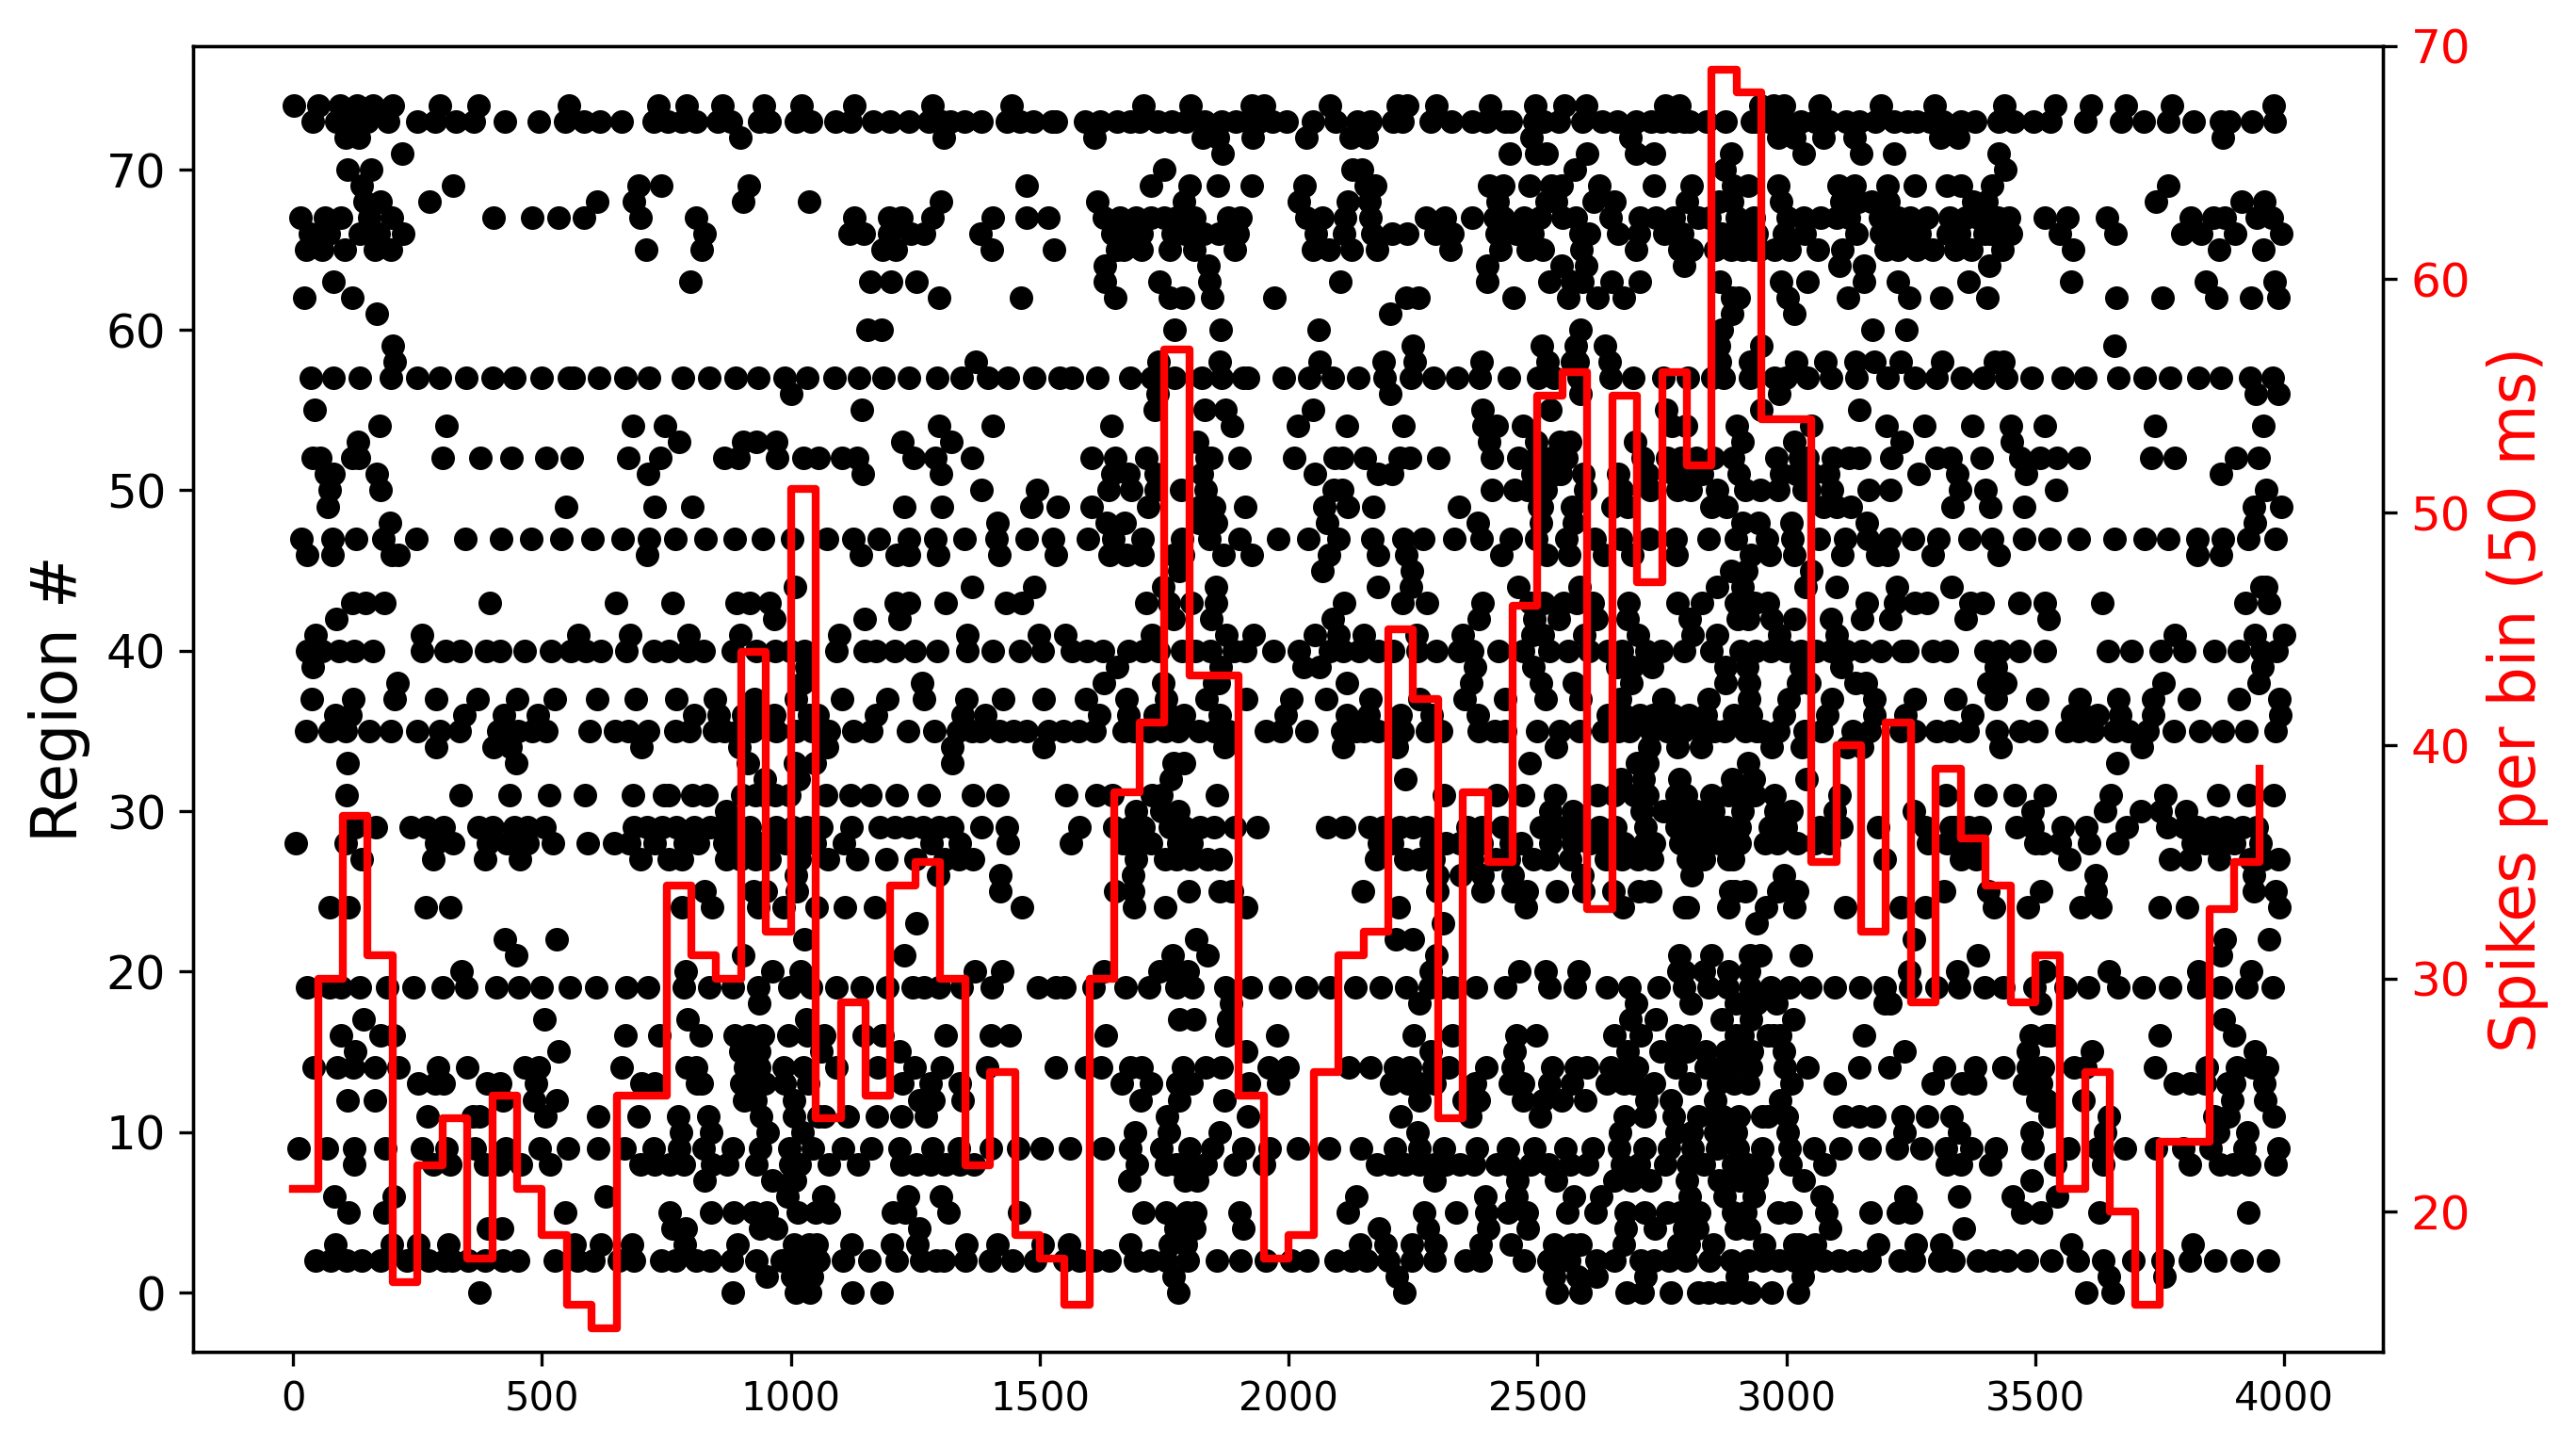

In [37]:
start = 0
end = 4000
stim_onset = 0 # no stim
bin_size = 50
r_hem = np.arange(75)
kTrial = 0 # no trials

count = []
fig = plt.figure(dpi=300, figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('region #', fontsize=16)
ax.set_xlabel('time (ms)', fontsize=16)
ax.tick_params(axis='y', labelsize=12)

for node in r_hem:
    Spikes, SpikeCount, t  = DictSpikesRegion(data=data_V, node=node, start=start, end=end, 
                                              bin_size=bin_size, stim_onset=stim_onset, 
                                              All_Trials=False, kTrial=kTrial)
    count.append(SpikeCount)
    Lk=len(Spikes['trial {}'.format(kTrial)])
    ax.plot(Spikes['trial {}'.format(kTrial)], np.repeat(node,Lk),'.', c='k',label='Right control', ms=10)

SpksBin = np.sum(count,axis=0)
ax2 = ax.twinx()
ax2.plot(t, SpksBin,'red',ds='steps-post',lw=2)
ax2.set_ylabel(f'Spikes per bin ({bin_size} ms)', color='red',fontsize=16)    
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
ax2.set_ylim(SpksBin.min()-1, SpksBin.max()+1);

## Hconn

In [44]:
t_start = 1000
t_end = 4000 + t_start

_, _, data_V, _, _ = run_sim(params=LB_HconnParams(), conn=Hconn, 
                            stim_amp = 0, # spontaneous activity
                            sim_length=t_end)
data_V = data_V[t_start:]

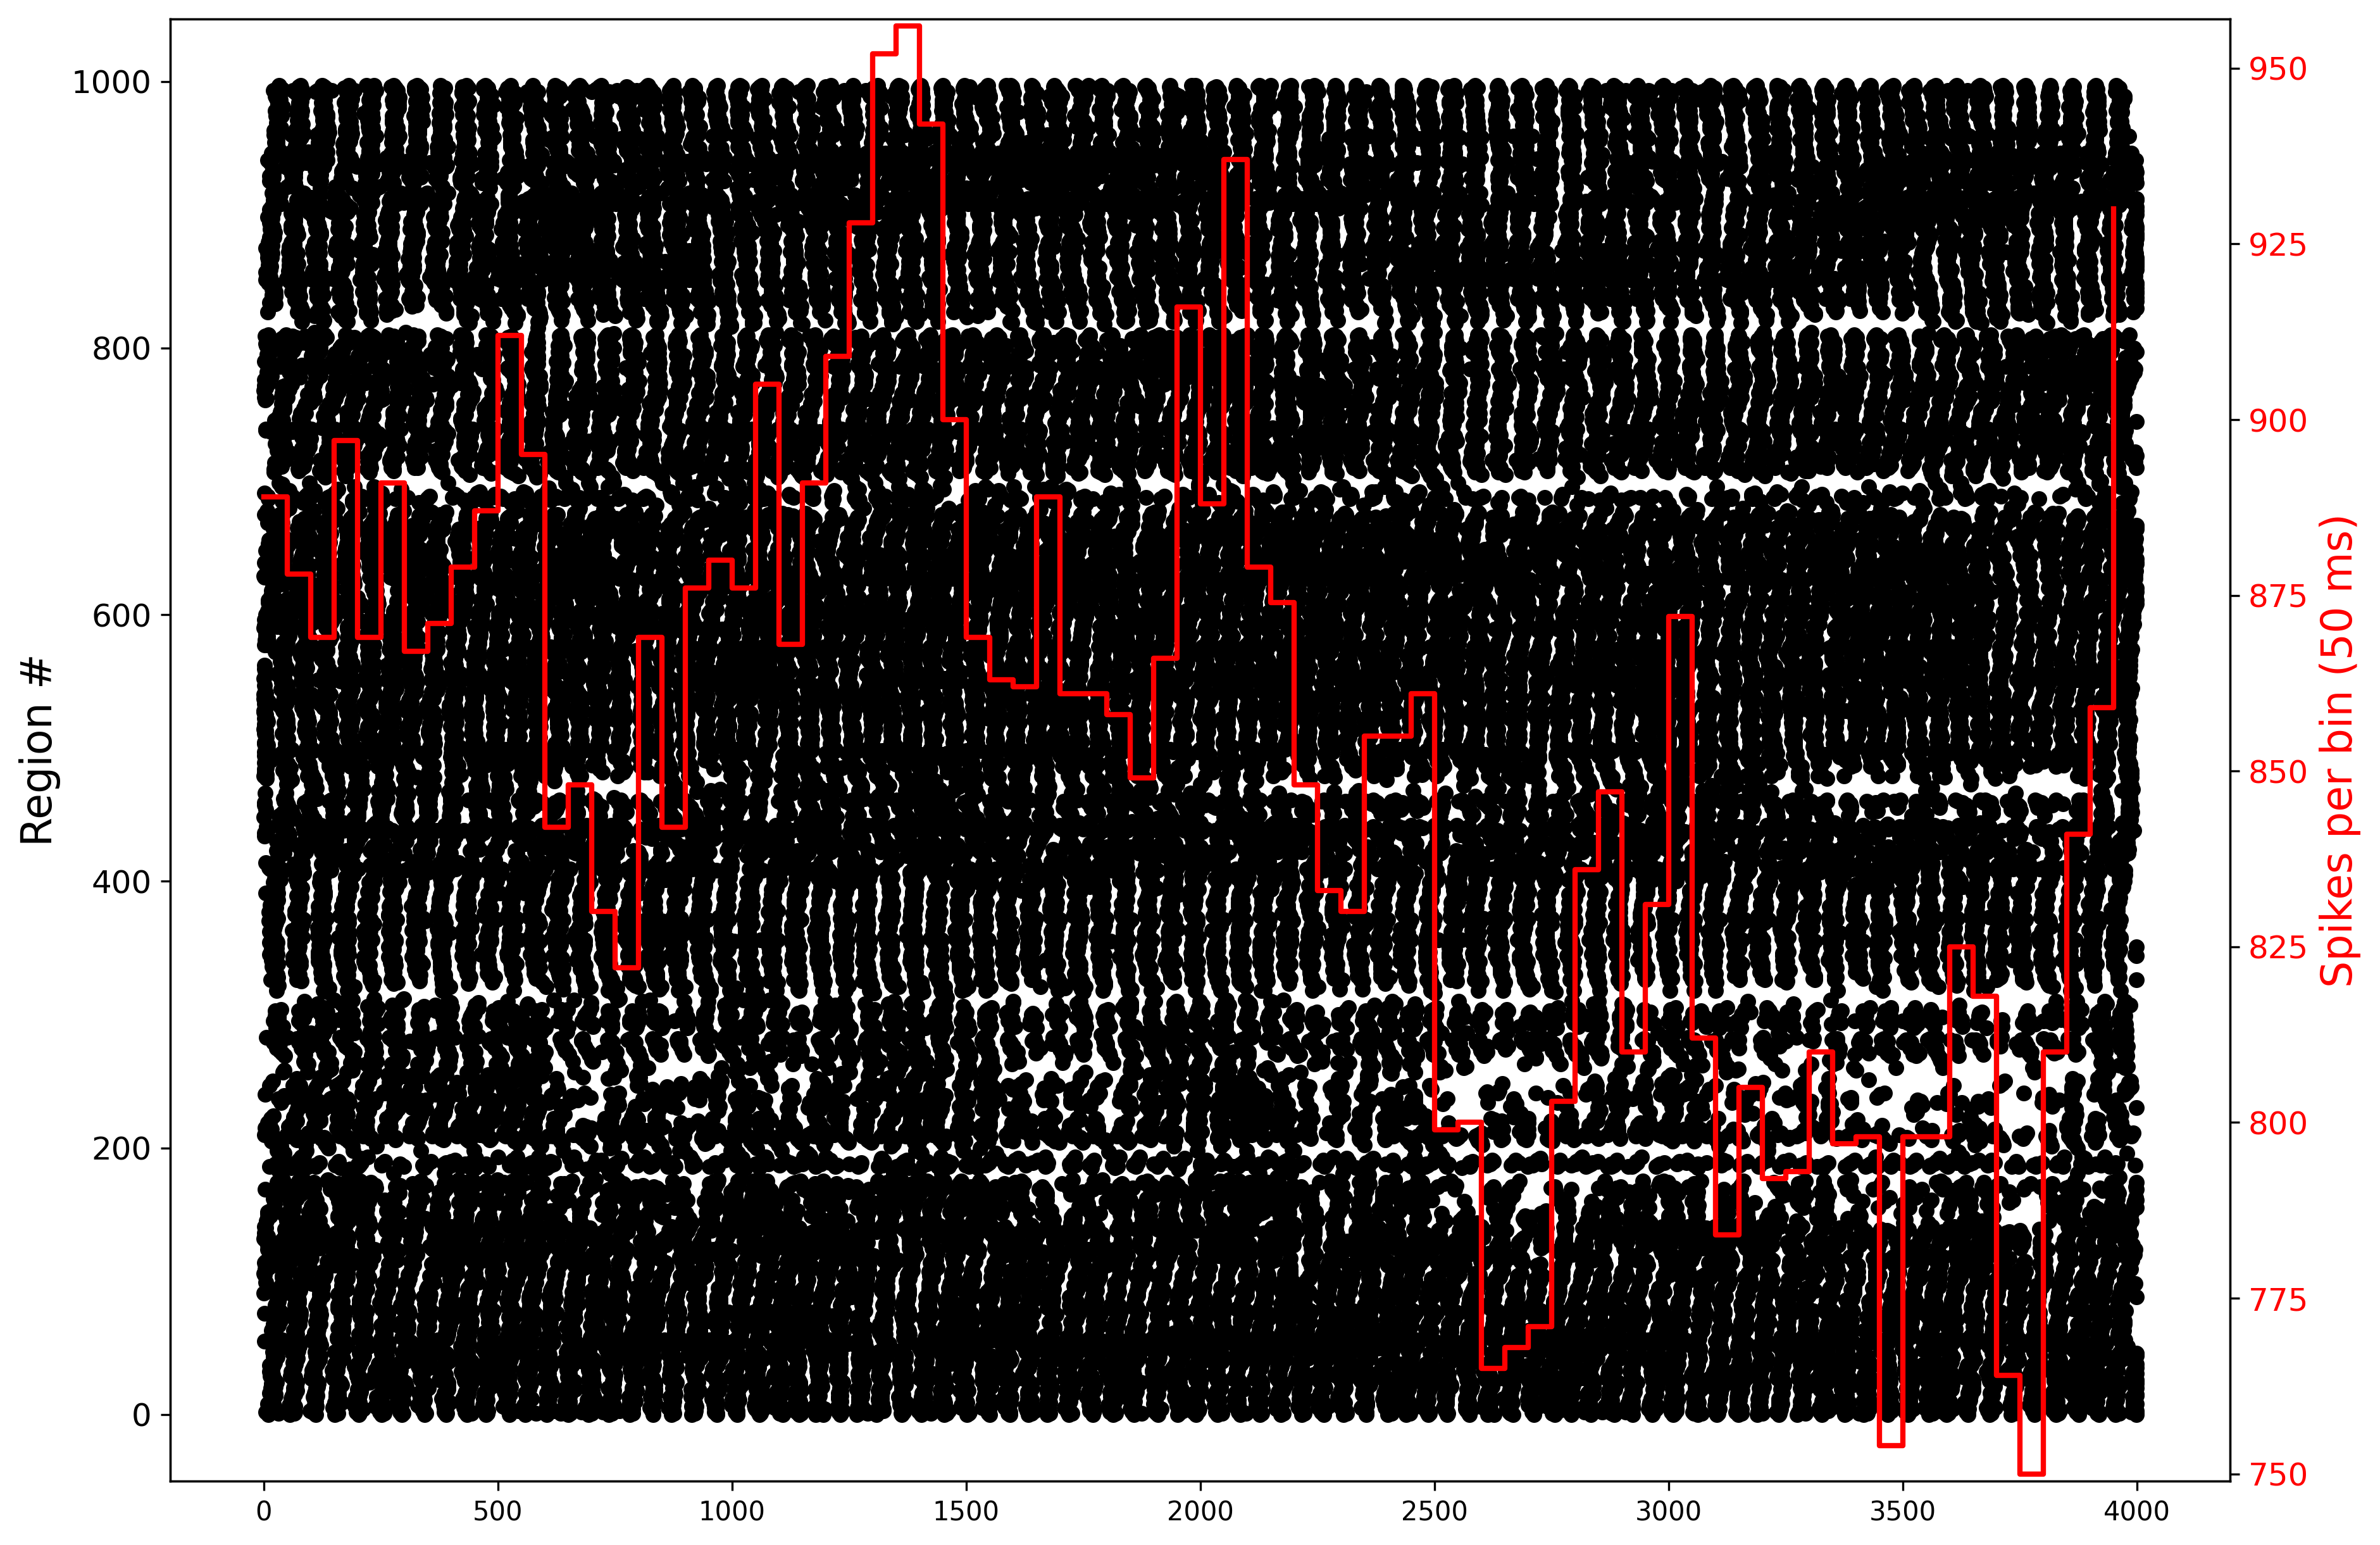

In [45]:
start = 0
end = 4000
stim_onset = 0 # no stim
bin_size = 50
r_hem = np.arange(998)
kTrial = 0 # no trials

count = []
fig = plt.figure(dpi=300, figsize=(14,10))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('region #', fontsize=16)
ax.set_xlabel('time (ms)', fontsize=16)
ax.tick_params(axis='y', labelsize=12)

for node in r_hem:
    Spikes, SpikeCount, t = DictSpikesRegion(data=data_V, node=node, start=start, end=end, 
                                             bin_size=bin_size, stim_onset=stim_onset, 
                                             All_Trials=False, kTrial=kTrial)
    count.append(SpikeCount)
    Lk=len(Spikes['trial {}'.format(kTrial)])
    ax.plot(Spikes['trial {}'.format(kTrial)], np.repeat(node,Lk),'.', c='k',label='Right control', ms=10)

SpksBin = np.sum(count,axis=0)
ax2 = ax.twinx()
ax2.plot(t, SpksBin,'red',ds='steps-post',lw=2)
ax2.set_ylabel(f'Spikes per bin ({bin_size} ms)', color='red',fontsize=16)    
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
ax2.set_ylim(SpksBin.min()-1, SpksBin.max()+1);

# Evoked activity

In [59]:
def run_evoked(conn, params, stim_node, ntrials=500, 
               manipulated_nodes=[], manipulation_params=[], fit_nodes=[], fit_params=[],
               stim_amp=1, stim_tau=5, pre=1000, post=1000, stimulus_jitter=[3000,5000]):
    
    V_trials = []
    for trial in range(ntrials):
        stim_onset = np.random.randint(stimulus_jitter[0], stimulus_jitter[1])
        sim_start = stim_onset - pre
        sim_end = stim_onset + post 

        _, _, data_V, _, _ = run_sim(conn=conn, params=params,
                                     stim_amp = stim_amp, stim_onset=stim_onset, stim_tau=stim_tau, stim_node=[stim_node], stim_T=50000, 
                                     sim_length=sim_end)
        data_V = data_V[sim_start:,:]
        V_trials.append([data_V])
        sys.stdout.write('\rTrial: ' + str(trial+1) + ' of ' + str(ntrials))
        sys.stdout.flush()
        
    time = np.arange(-pre,post)
    V_trials = np.squeeze(V_trials)
    IFR_trials, TimeBins = calc_firing_trials(V_trials, time, bin_size=25, start=0, end=pre+post, stim_onset=pre, conn=conn.weights, sliding=True, step=10)
    
    return IFR_trials, TimeBins, V_trials, time

In [63]:
stim_node = 13

IFR_trials, tb, V_trials, t = run_evoked(Dconn, LB_DconnParams(), stim_node, ntrials=100, 
                                         stim_amp=1, pre=1000, post=1000, stimulus_jitter=[3000,5000]) 

Trial: 100 of 100

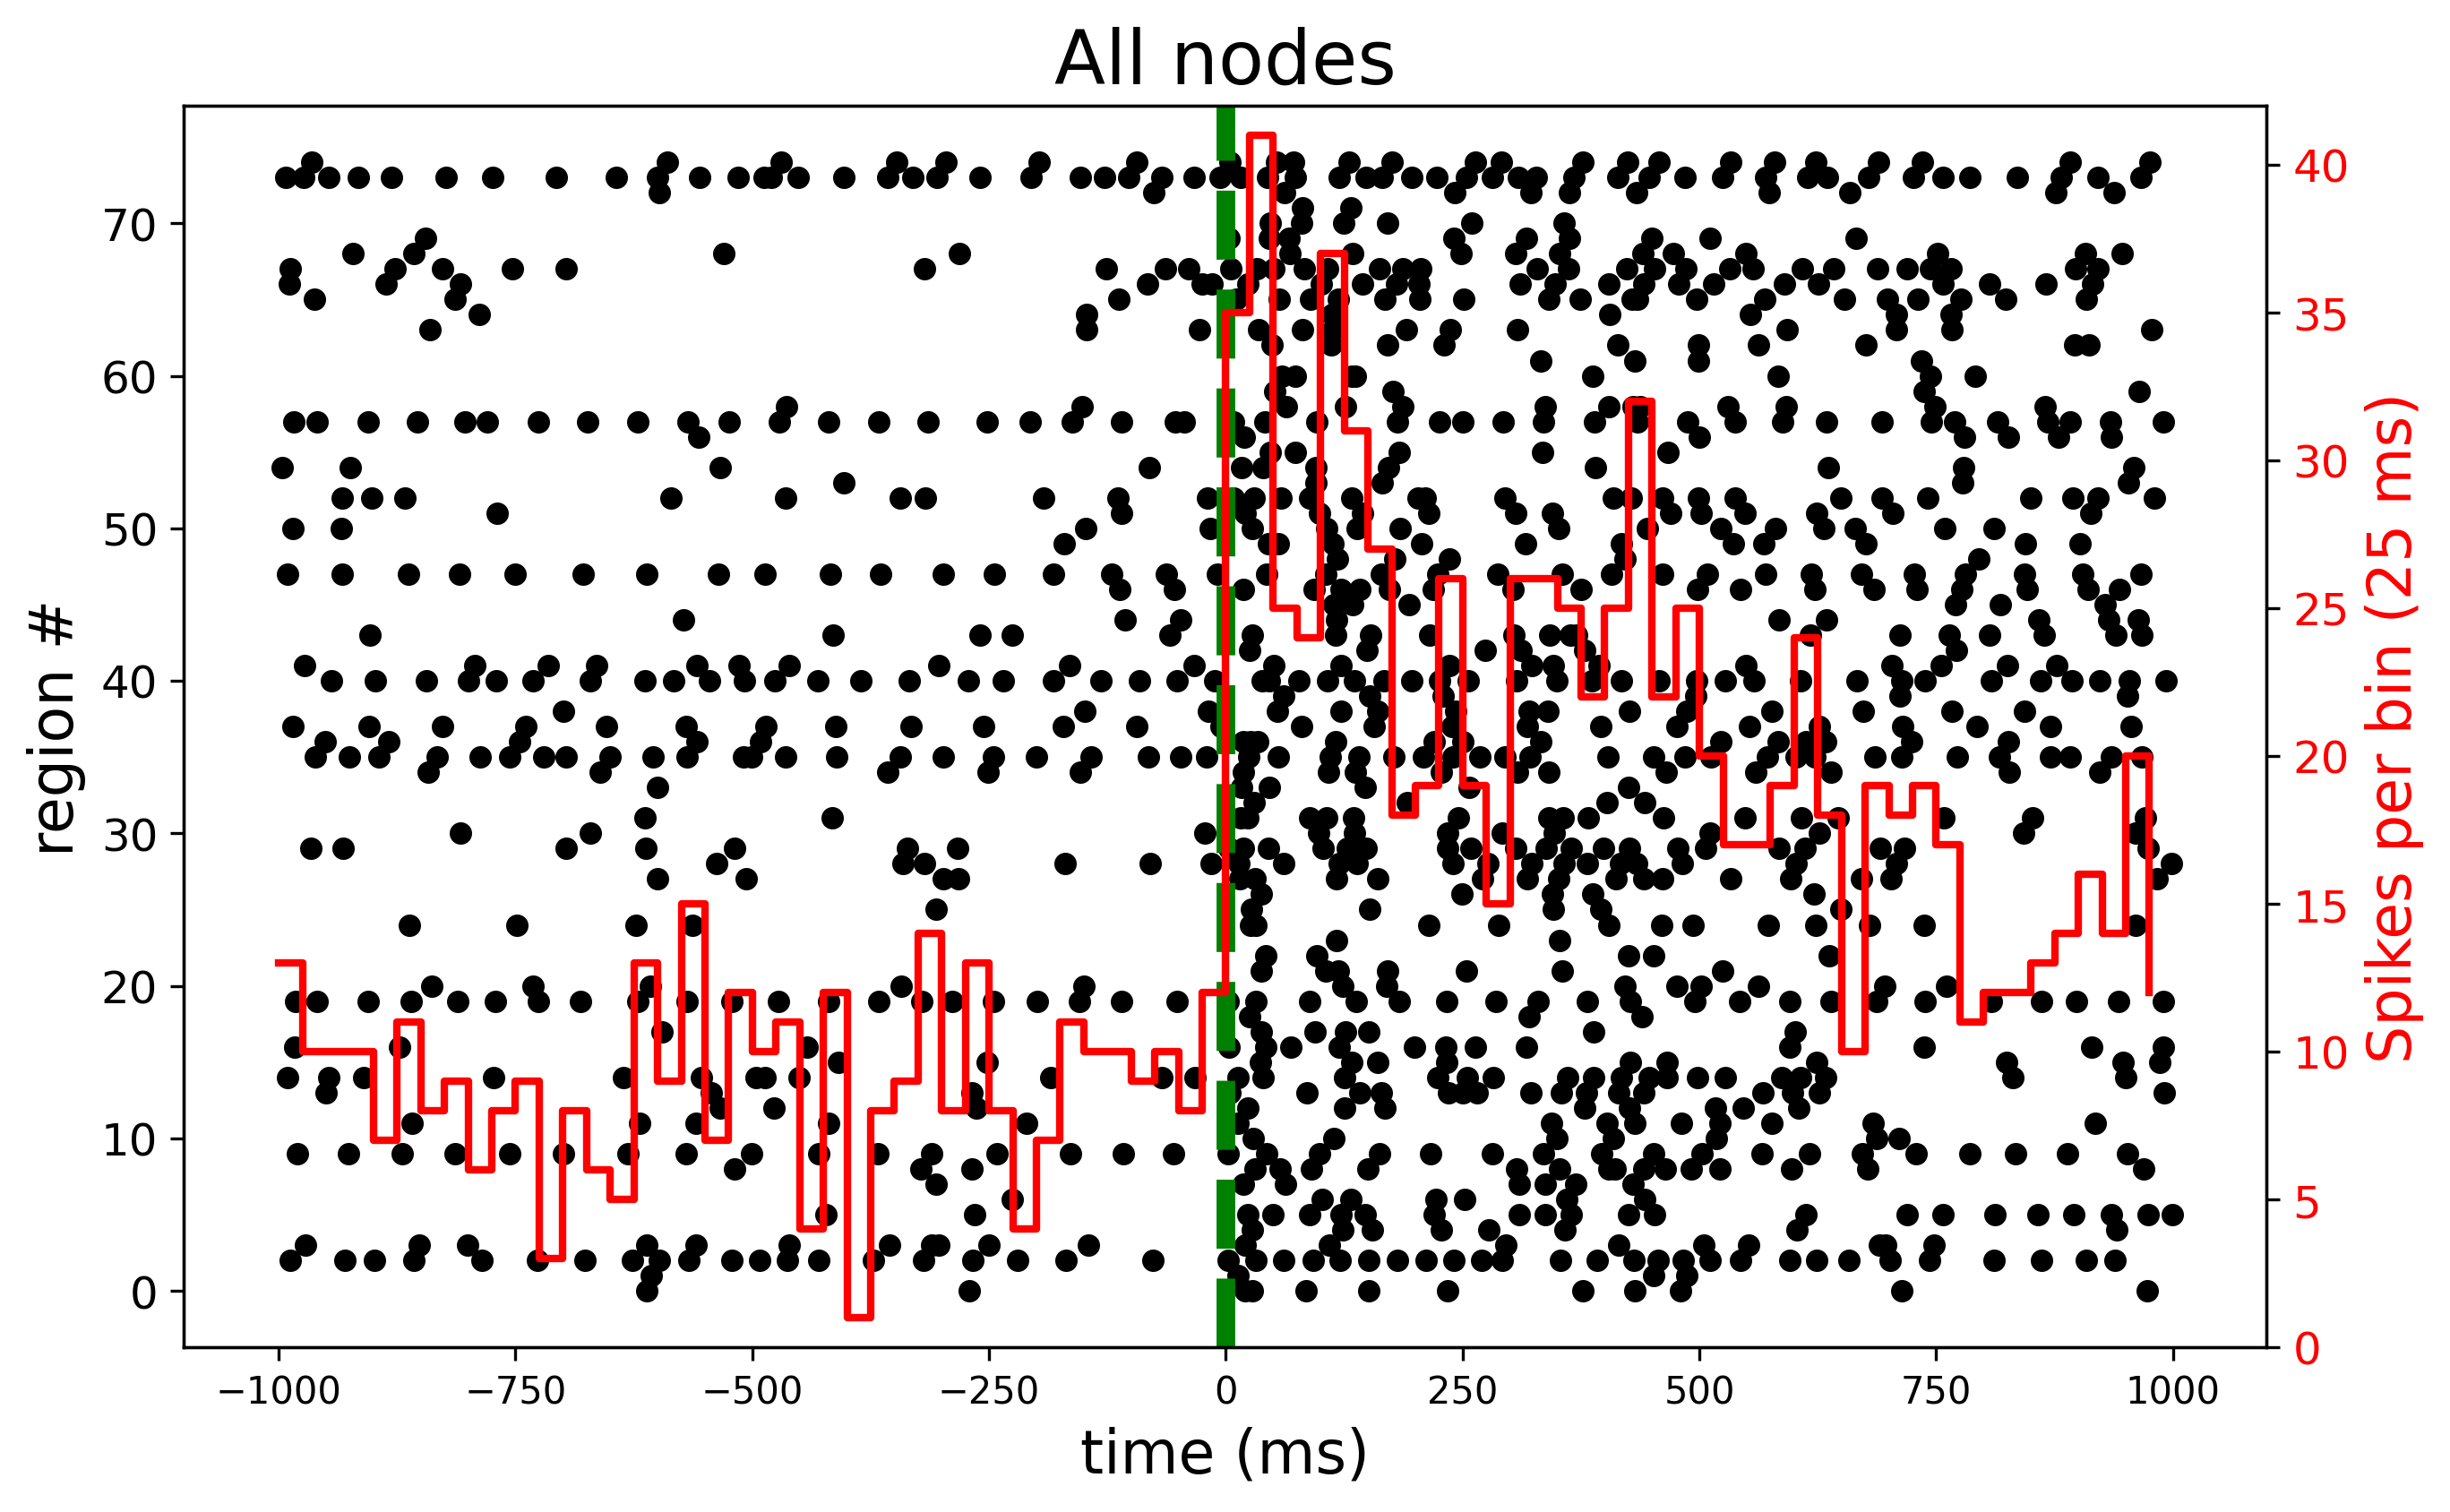

In [100]:
start = 0
end = 2000
stim_onset = 1000 
bin_size = 25
r_hem = np.arange(75)
kTrial = 10

count = []
fig = plt.figure(dpi=300, figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('region #', fontsize=16)
ax.set_xlabel('time (ms)', fontsize=16)
ax.tick_params(axis='y', labelsize=12)
ax.set_title('All nodes', fontsize=20)
for node in r_hem:
    Spikes, SpikeCount, t  = DictSpikesRegion(data=V_trials, node=node, start=start, end=end, 
                                              bin_size=bin_size, stim_onset=stim_onset, 
                                              All_Trials=False, kTrial=kTrial)
    count.append(SpikeCount)
    Lk=len(Spikes['trial {}'.format(kTrial)])
    ax.plot(Spikes['trial {}'.format(kTrial)], np.repeat(node,Lk),'.', c='k',label='Right control', ms=10)

SpksBin = np.sum(count,axis=0)
ax2 = ax.twinx()
ax2.plot(t, SpksBin,'red',ds='steps-post', lw=2)
ax2.set_ylabel(f'Spikes per bin ({bin_size} ms)', color='red',fontsize=16)    
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
ax2.set_ylim(SpksBin.min()-1, SpksBin.max()+1);
ax.axvline(0, color='green', lw=5, ls='--');

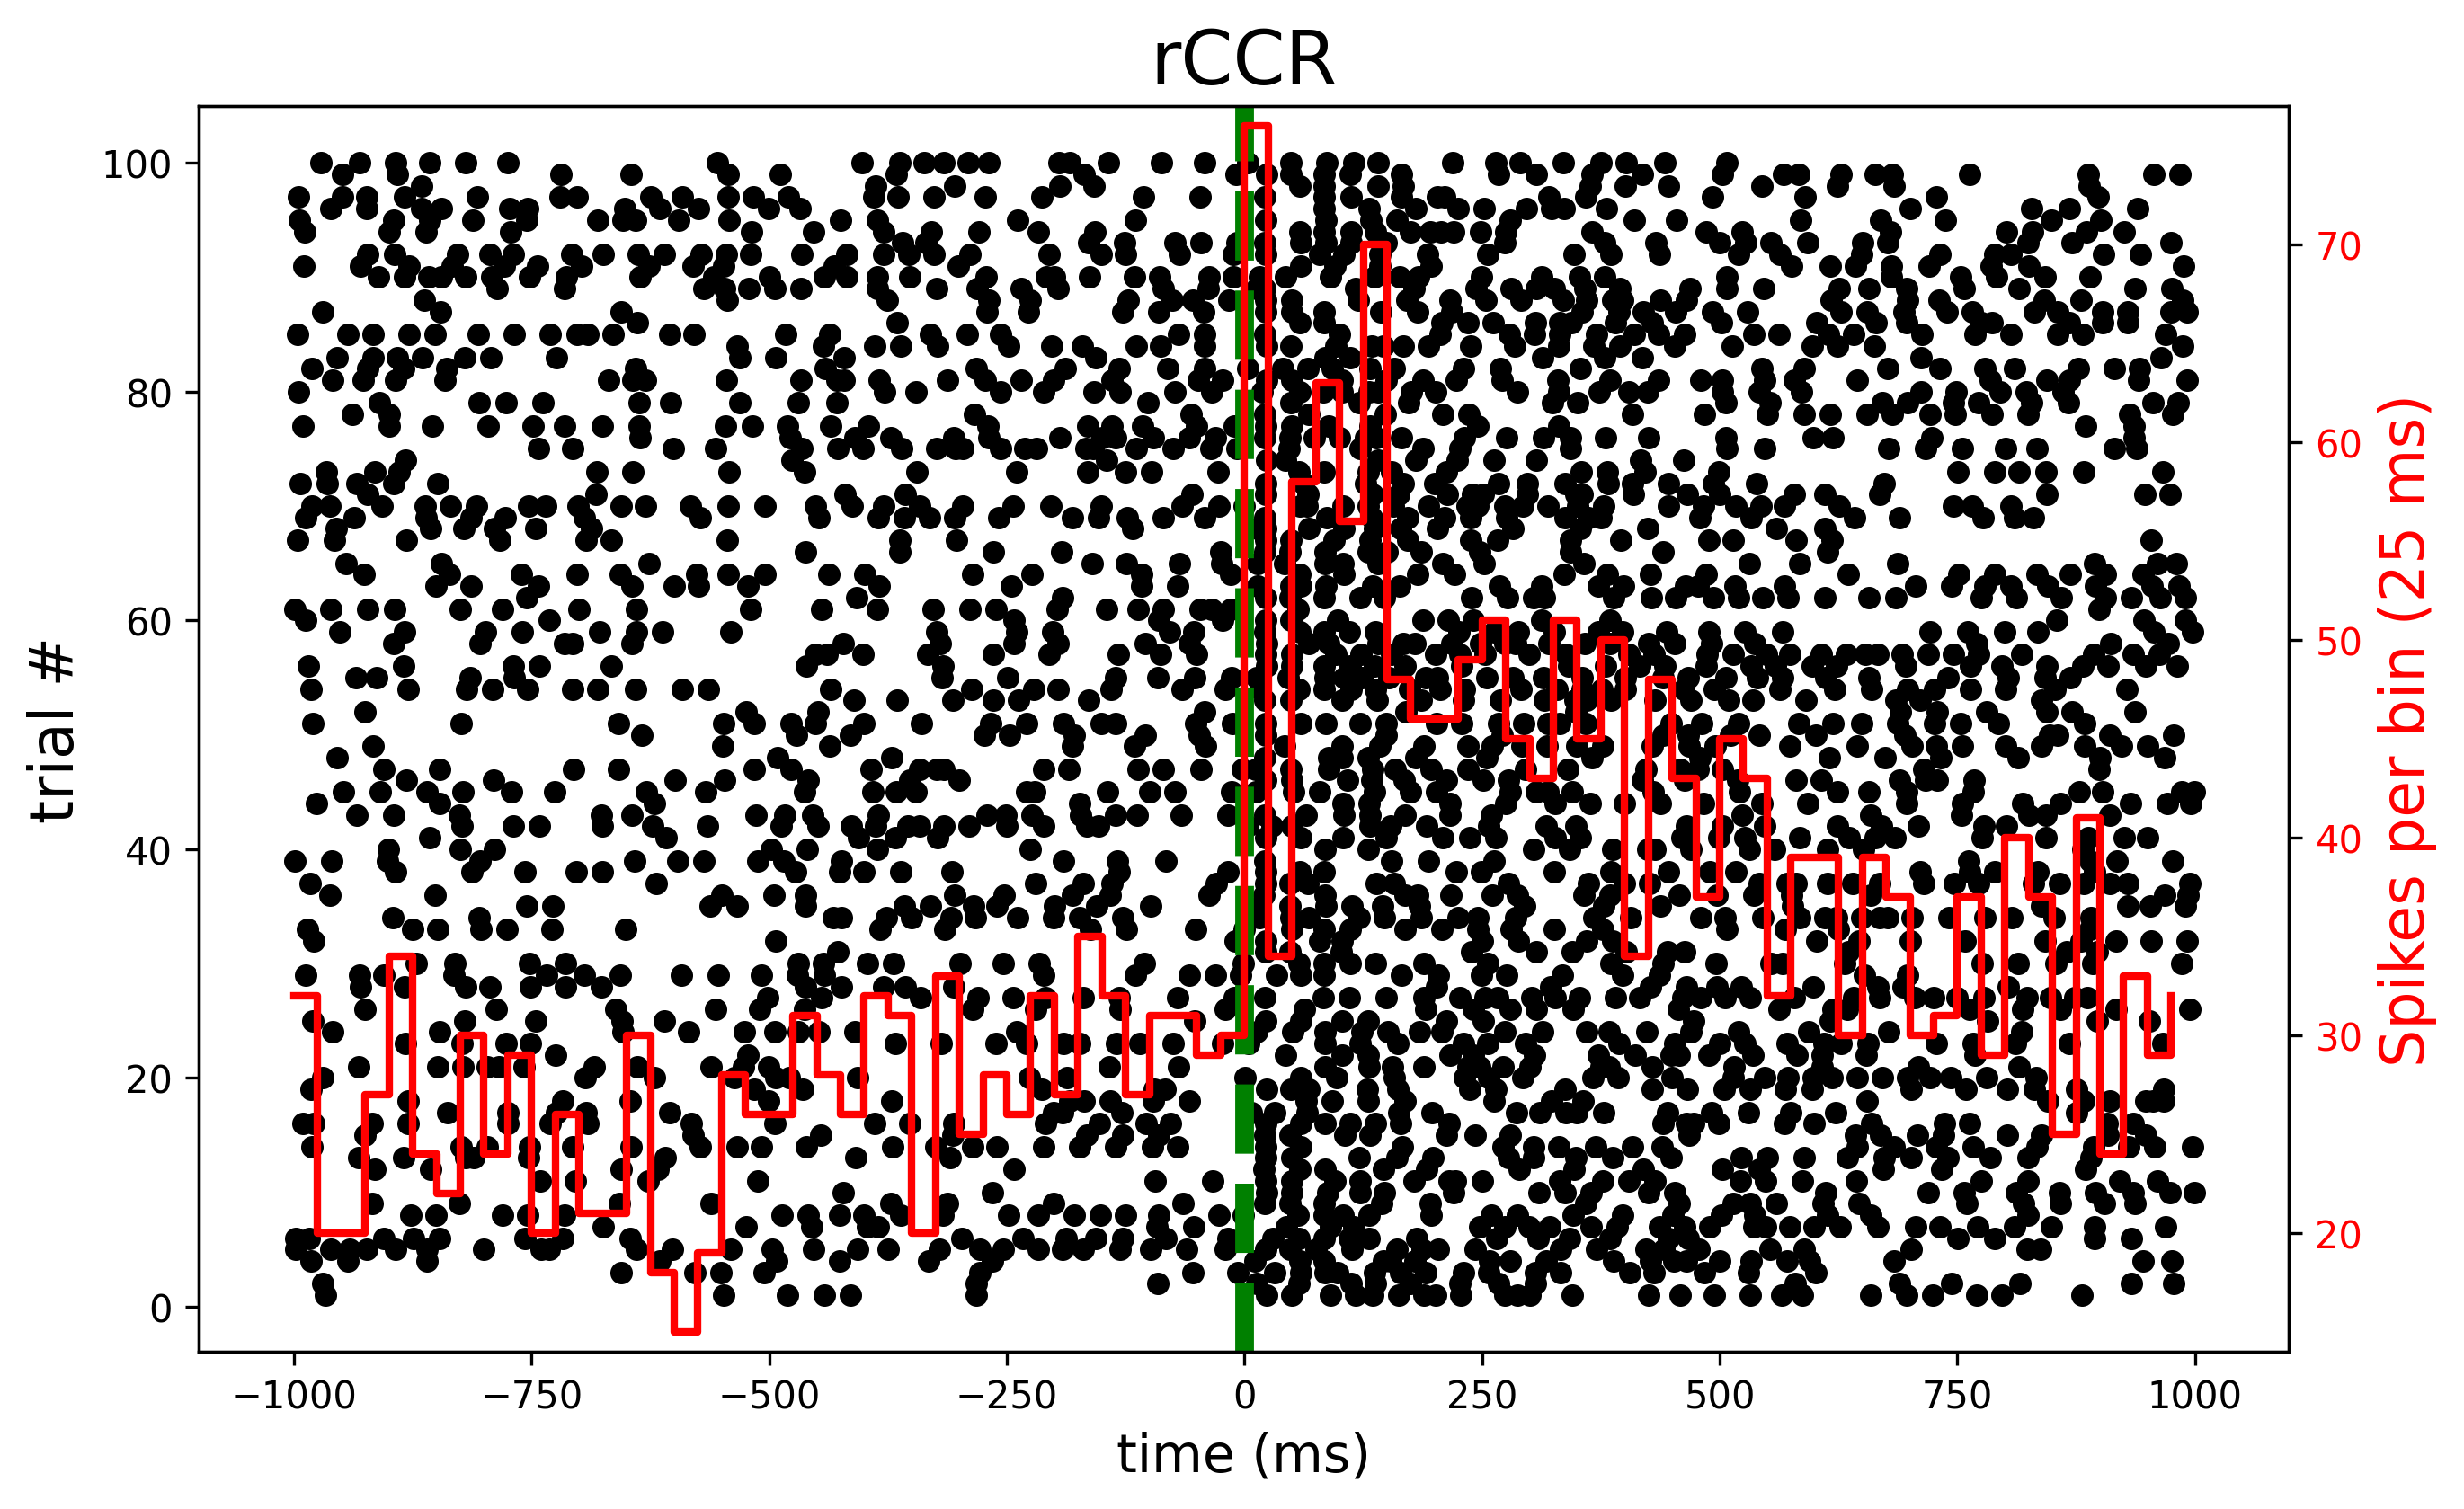

In [105]:
node = 5
bin_size = 25
start = 0
end = 2000
stim_onset = 1000

fig = plt.figure(dpi=300, figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.set_title(Dconn.region_labels[node], fontsize=20)

Spikes, SpikeCount, t = DictSpikesRegion(data=V_trials, node=node, start=start, end=end, 
                                         bin_size=bin_size,stim_onset=stim_onset, All_Trials=True)

for k in range(len(Spikes)):
    Lk=len(Spikes['trial {}'.format(k+1)])
    ax.plot(Spikes['trial {}'.format(k+1)], np.repeat(k+1,Lk),'k.', ms=10)
ax.set_ylabel('trial #', fontsize=16)
ax.set_xlabel('time (ms)', fontsize=14)
ax2 = ax.twinx()
ax2.plot(t, SpikeCount, color='r',linewidth='2', linestyle='-',ds='steps-post' )
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(np.array(SpikeCount).min()-1, np.array(SpikeCount).max()+1);
ax2.set_ylabel(f'Spikes per bin ({bin_size} ms)', color='red',fontsize=16)    
ax.axvline(0, color='green', lw=5, ls='--');

Text(0, 0.5, 'IFR (Hz)')

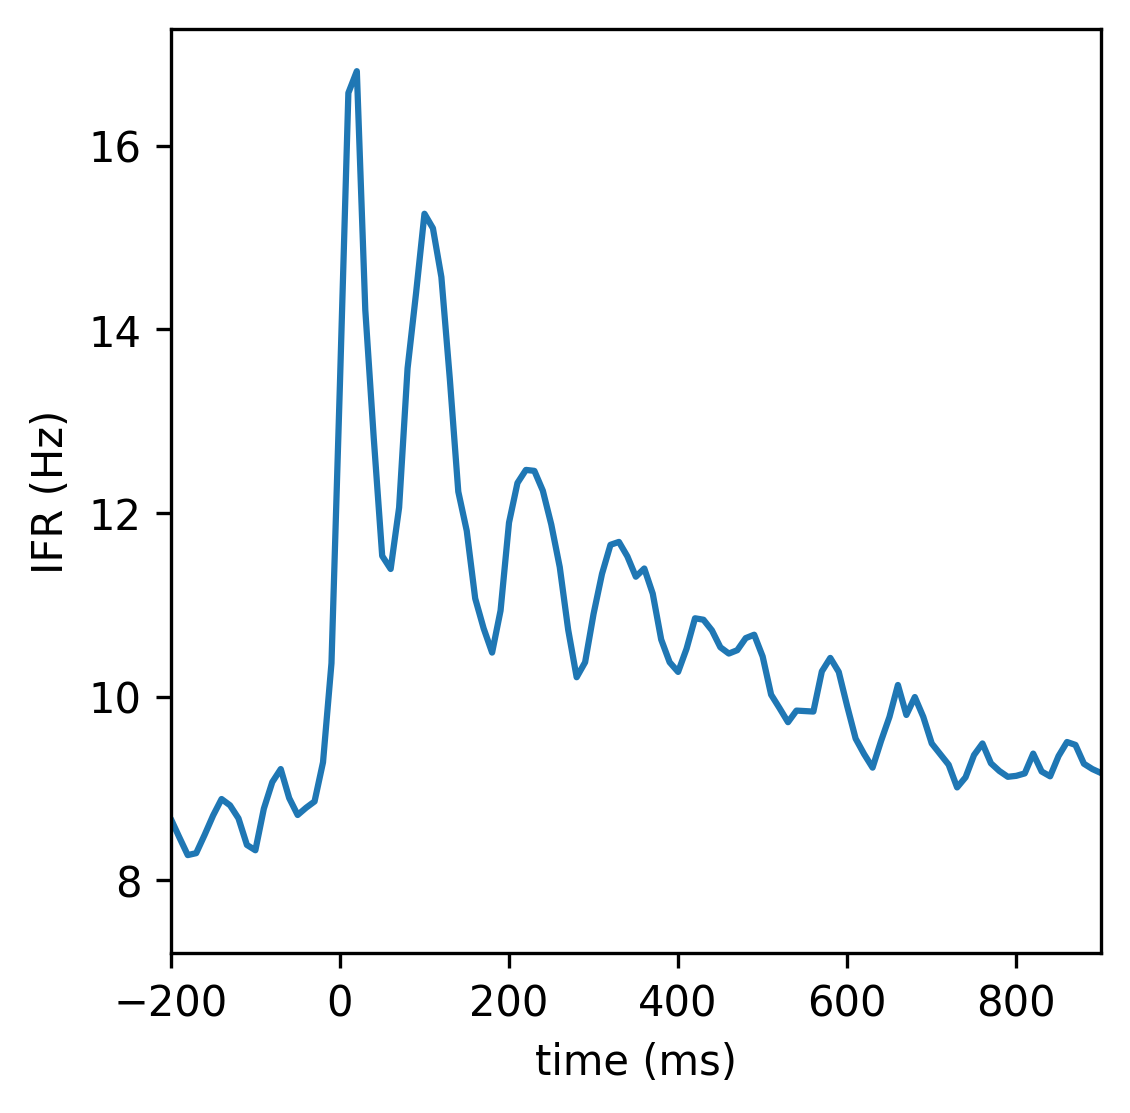

In [122]:
plt.figure(dpi=300, figsize=(4,4))
# mean across trials and nodes
plt.plot(tb, IFR_trials.mean(axis=0).mean(axis=0))
plt.xlim(-200, 900)
plt.xlabel('time (ms)')
plt.ylabel('IFR (Hz)')